In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import statsmodels.api as sm
import keras
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


# Problem: Stayzilla Listing Room Price Prediction

# 1. Visual EDA

In [2]:
# load the data 
price_data = pd.read_csv("priceData.csv")
price_data = price_data.iloc[:,2:].drop(columns=['property_id'])

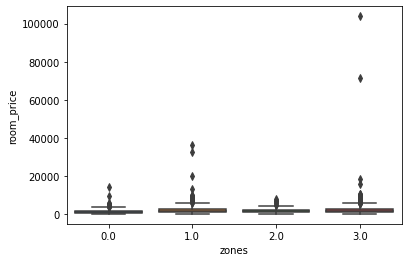

In [4]:
# check the room price outliner 
sns.boxplot(x="zones", y="room_price", data=price_data)

In [5]:
# check the interquartile range to remove outliers
from scipy.stats import iqr
1.5*iqr(price_data.room_price) + price_data.room_price.mean(),  price_data.room_price.mean() - 1.5*iqr(price_data.room_price) 

(4532.537313432836, -159.46268656716438)

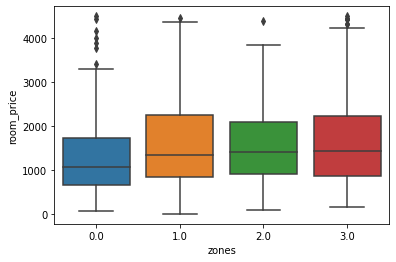

In [3]:
# remove price higher than $4536

train_data = price_data[(price_data.room_price < 4536) & (price_data.room_price > 0)]
sns.boxplot(x="zones", y="room_price", data=train_data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae01643110>,
      dtype=object)

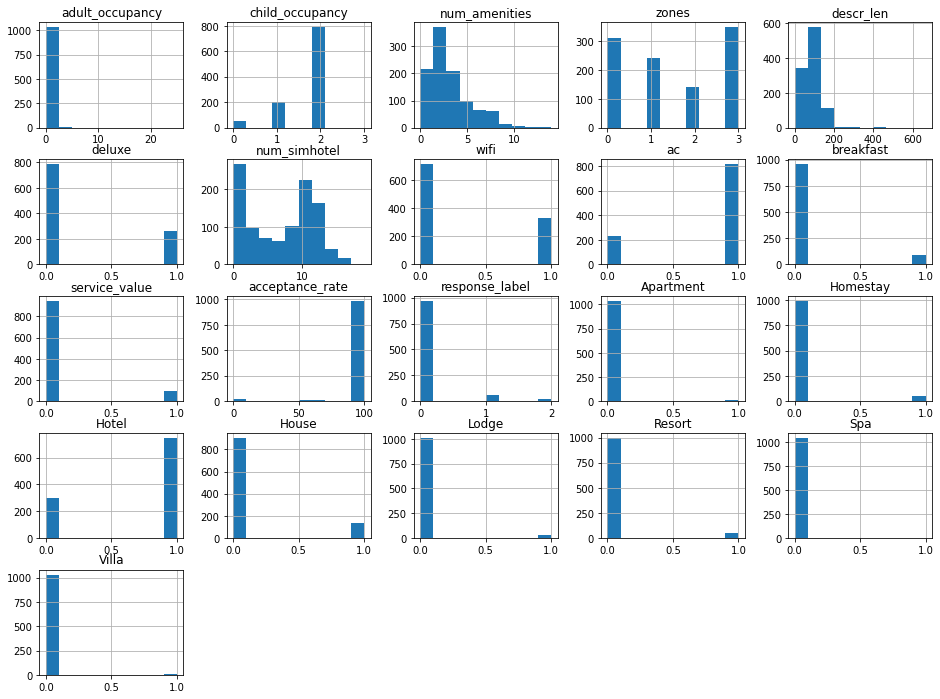

In [104]:
# inspect with visuals 
train_data.iloc[:,2:].hist(figsize=(16,12))

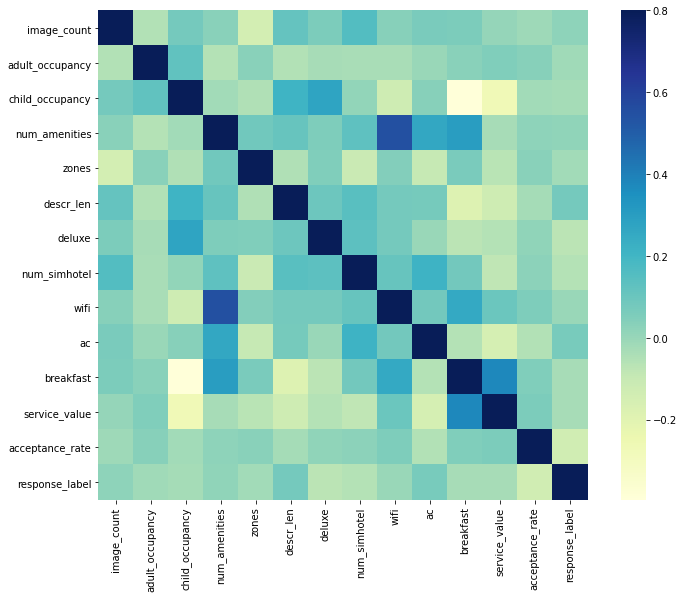

In [18]:
# check the correlation 
corrmat = train_data.iloc[:, 1:-8].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, cmap="YlGnBu");

# 2. Prediction

## 2.1 Linear regression 

In [146]:
from sklearn.linear_model import LinearRegression
# fit all features 
X = preprocessing.scale(train_data.iloc[:,1:])
y = train_data.iloc[:,0]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

lr_model = LinearRegression()

# fit the model
lr_model.fit(X_train, y_train)

LinearRegression()

In [33]:
from sklearn.metrics import mean_squared_error 

# compute test MSE 
y_true_lr = y_test # Y_true = Y (original values) 
y_pred_lr = lr_model.predict(X_test) # Y_pred = Y' 
lr_testMSE = mean_squared_error(y_true_lr,y_pred_lr) 

# training mse
y_true_train_lr = y_train  
y_pred_train_lr = lr_model.predict(X_train) 
lr_trainMSE = mean_squared_error(y_true_train_lr,y_pred_train_lr) 
print(lr_testMSE, lr_trainMSE)

# get adjusted r2
def adj_r2(r2, n, p):
    '''
    p is the number of features
    n is the sample size (i.e. test test here)
    '''
    return 1-(1-r2)*(n-1)/(n-p-1)

from sklearn.metrics import r2_score
lr_r2 = r2_score(y_true_lr, y_pred_lr)
lr_r2_adj = adj_r2(lr_r2, 209, 22)
print(lr_r2_adj)


622797.9826447262 681500.6528661315
0.21371039041823114


## 2.2 Linear regression using Gradien descent  

In [127]:
# fit all features 
import numpy as np
X = preprocessing.scale(train_data.iloc[:,1:])
X = sm.add_constant(X)
y = train_data.iloc[:,0]
y = y.to_numpy()
y = np.expand_dims(y, axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)


In [128]:
# define a gradient descent function 
def grad_descent(X, y, alpha, epsilon):
    iteration = [0]
    i = 0
    theta = np.ones(shape=(X.shape[1], 1))
    
    # X = X + np.array([1,0])
    
    cost = [np.transpose(X @ theta - y) @ (X @ theta - y)]
    delta = 1
    while (delta>epsilon):
        
        theta = theta - alpha*((np.transpose(X)) @ (X @ theta - y))
        cost_val = (np.transpose(X @ theta - y)) @ (X @ theta - y)
        cost.append(cost_val)
        delta = abs(cost[i+1]-cost[i])
        if ((cost[i+1]-cost[i]) > 0):
            print("The cost is increasing. Try reducing alpha.")
            break
        iteration.append(i)
        i += 1
        
    print("Completed in %d iterations." %(i))
    return theta, cost 


# get the theta

theta1, cost_hist1 = grad_descent(X = X_train, y=y_train, alpha=0.0001, epsilon = 10**-10)

Completed in 393 iterations.


Text(0.5, 1.0, 'Convergence of gradient descent')

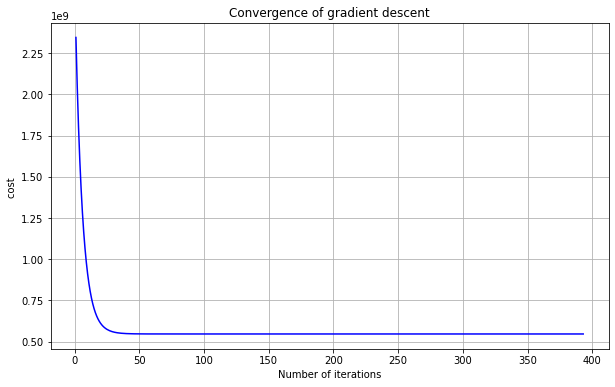

In [129]:
# plot the cost 
import matplotlib.pyplot as plt
plt.plot(range(1, len(cost_hist1)), [cost_hist1[i][0][0] for i in range(1, len(cost_hist1))], color ='blue')
plt.rcParams["figure.figsize"] = (10,6)
plt.grid()
plt.xlabel("Number of iterations")
plt.ylabel("cost ")
plt.title("Convergence of gradient descent")

In [130]:
# get the predicted values 
y_hat = X_test.dot(theta1)

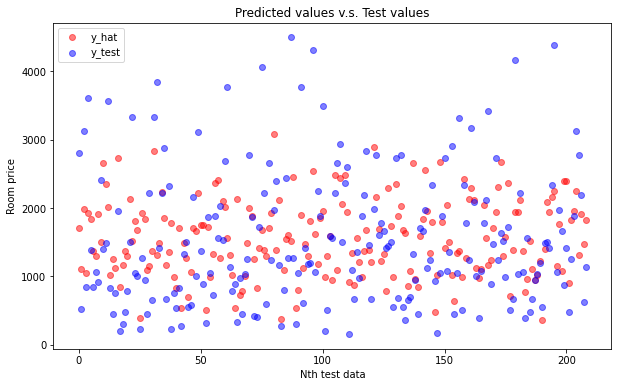

In [131]:
# plot to see the prediction results 
plt.figure()
plt.scatter(x=list(range(0, len(y_hat))),y= y_hat, color='red', alpha=0.5, label='y_hat')         
plt.scatter(x=list(range(0, len(y_test))), y=y_test, color='blue', alpha=0.5, label='y_test')
plt.xlabel("Nth test data")
plt.ylabel('Room price')
plt.title("Predicted values v.s. Test values")
plt.legend()
plt.show()

In [132]:
# evaluate MSE
y_true_GD = y_test # Y_true = Y (original values) 
y_pred_GD = y_hat # Y_pred = Y' 
# Calculation of Mean Squared Error (MSE) 
GD_testMSE = mean_squared_error(y_true_GD,y_pred_GD) 
print('GD test MSE:', GD_testMSE)

y_true_train_GD = y_train  
y_pred_train_GD = X_train.dot(theta1)  
# Calculation of Mean Squared Error (MSE) 
GD_trainMSE = mean_squared_error(y_true_train_GD,y_pred_train_GD) 
print('GD train MSE:', GD_trainMSE)

GD test MSE: 739126.3736439272
GD train MSE: 653819.5896294954


In [123]:
# get adjusted r square
gd_r2 = r2_score(y_true_GD,y_pred_GD)
gd_r2_adj = adj_r2(gd_r2, 209, 22)
gd_r2_adj

0.1694601514137305

## 2.3 Random Forest Regression

In [94]:
from sklearn.ensemble import RandomForestRegressor
X = preprocessing.scale(train_data.iloc[:,1:])
y = train_data.iloc[:,0]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

# fit a model 
rr = RandomForestRegressor(n_estimators = 1000)
rr.fit(X_train, y_train.values.ravel())

RandomForestRegressor(n_estimators=1000)

In [43]:
# get MSE
y_true_train_rr = y_train  
y_pred_train_rr = rr.predict(X_train) 
rr_trainMSE = mean_squared_error(y_true_train_rr,y_pred_train_rr) 

y_true_rr = y_test 
y_pred_rr = rr.predict(X_test)  
rr_testMSE = mean_squared_error(y_true_rr,y_pred_rr) 
rr_trainMSE, rr_testMSE

(94214.56925006685, 665579.9283758245)

In [44]:
# calculate adjusted r2
from sklearn.metrics import r2_score
rr_r2 = r2_score(y_true_rr, y_pred_rr)
rr_r2_adj = adj_r2(rr_r2, 209, 22)
rr_r2_adj

0.19462446853081494

## 2.4 Neural Network

In [86]:
# define x, y
X = train_data.iloc[:,1:].values
y = train_data.iloc[:,0].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

In [87]:
# define NN model
nn = Sequential()
nn.add(Dense(22, activation='linear'))
nn.add(Dense(200,activation='relu'))
nn.add(Dense(10, activation='relu')) 
nn.add(Dense(1,activation='linear'))
nn.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])
nn.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
27/27 [==============================] - 1s 8ms/step - loss: 3127048.8482 - mse: 3127048.8482 - mae: 1494.6670 - val_loss: 3463772.5000 - val_mse: 3463772.5000 - val_mae: 1579.4436
Epoch 2/20
27/27 [==============================] - 0s 3ms/step - loss: 3119664.9107 - mse: 3119664.9107 - mae: 1474.5581 - val_loss: 3441358.0000 - val_mse: 3441358.0000 - val_mae: 1572.5995
Epoch 3/20
27/27 [==============================] - 0s 3ms/step - loss: 3171715.2857 - mse: 3171715.2857 - mae: 1486.2027 - val_loss: 3388762.7500 - val_mse: 3388762.7500 - val_mae: 1556.9144
Epoch 4/20
27/27 [==============================] - 0s 3ms/step - loss: 3226987.6339 - mse: 3226987.6339 - mae: 1515.8075 - val_loss: 3264638.5000 - val_mse: 3264638.5000 - val_mae: 1519.7440
Epoch 5/20
27/27 [==============================] - 0s 3ms/step - loss: 3025781.0268 - mse: 3025781.0268 - mae: 1448.7159 - val_loss: 2997226.7500 - val_mse: 2997226.7500 - val_mae: 1437.9933
Epoch 6/20
27/27 [======================

In [88]:
# get the MSE
y_true_train_nn = y_train  
y_pred_train_nn = nn.predict(X_train) 
nn_trainMSE = mean_squared_error(y_true_train_nn,y_pred_train_nn) 

y_true_nn = y_test
y_pred_nn = nn.predict(X_test)  
nn_testMSE = mean_squared_error(y_true_nn,y_pred_nn) 
nn_trainMSE, nn_testMSE

(740244.526906311, 741190.4636916795)

In [89]:
# get adjusted r sqaure
nn_r2 = r2_score(y_true_nn, y_pred_nn)
nn_r2_adj = adj_r2(nn_r2, 209, 22)
nn_r2_adj

0.1448989423771787

* Using neural network still does not yield good results. 
* We may conclude that the features as a whole in the dataset do not contribute to the change of room price that much. 

# 3. Results

In [133]:
# store all model metrics 
result = {'gradienr_descent': [GD_trainMSE, GD_testMSE, gd_r2_adj], 
         'linear_regression': [lr_trainMSE, lr_testMSE, lr_r2_adj], 
         'random_forest':[rr_trainMSE, rr_testMSE, rr_r2_adj], 
         'neural_network': [nn_trainMSE, nn_testMSE, nn_r2_adj]}
df = pd.DataFrame.from_dict(result,orient='index', columns=['training_MSE', 'test_MSE', 'test_adjustedR2'])

Text(0.5, 1.0, 'MSE - Four Models')

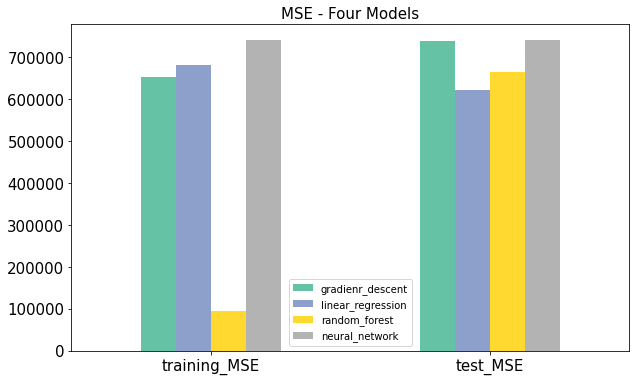

In [134]:
# plot MSE
df2 = df.transpose()
df2.iloc[:2,:].plot(kind='bar',colormap='Set2', rot=0, fontsize=15)
plt.title('MSE - Four Models', fontsize=15)

Text(0.5, 1.0, 'Adjusted R square - Four Models')

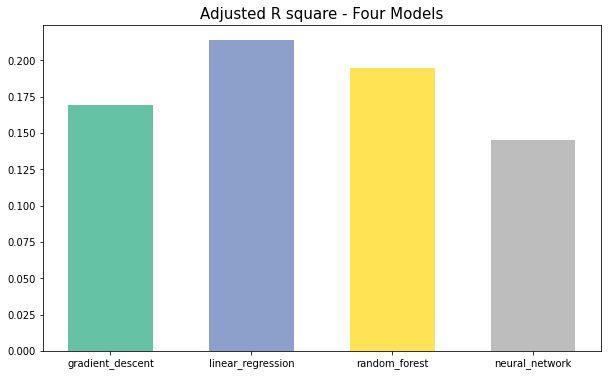

In [135]:
# plot adjusted r sqaure
x_pos = [0, 0.5, 1, 1.5]
bars = ('gradient_descent', 'linear_regression','random_forest', 'neural_network')
plt.xticks(x_pos, bars)
plt.bar(x=x_pos, 
            height=df2.iloc[2,:],color=['#66c2a5', '#8da0cb', '#ffe355', '#bdbdbd'], width=0.3)
plt.title('Adjusted R square - Four Models',fontsize=15)

In [136]:
df2

,gradienr_descent,linear_regression,random_forest,neural_network
training_MSE,653819.589629,681500.652866,94214.569250,740244.526906
test_MSE,739126.373644,622797.982645,665579.928376,741190.463692
test_adjustedR2,0.169460,0.213710,0.194624,0.144899


Text(0.5, 1.0, 'Linear Regression')

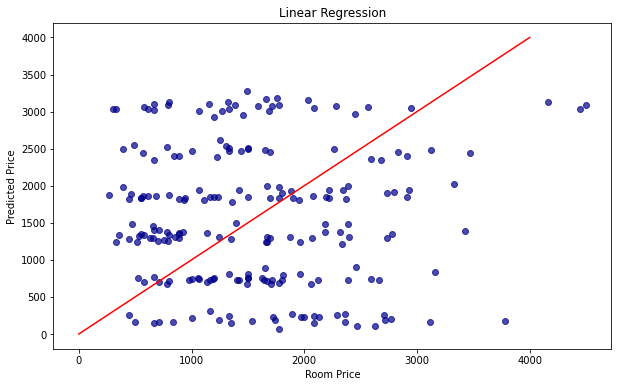

In [150]:
# rr model
x = room_price = train_data.iloc[-209:,0]
y = predicted_price = lr_model.predict(X_test)
fig, ax = plt.subplots()
plt.plot(x, y, 'o', color='darkblue', alpha=0.7)
plt.plot([0,4000],[0,4000], color='red')
plt.xlabel('Room Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression')

# 4. Alternative: try Predict price range

* I grouped the price into 6 buckets and to see if turning it into a classification problem would yield better result or not. 

/Users/yajiezhu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


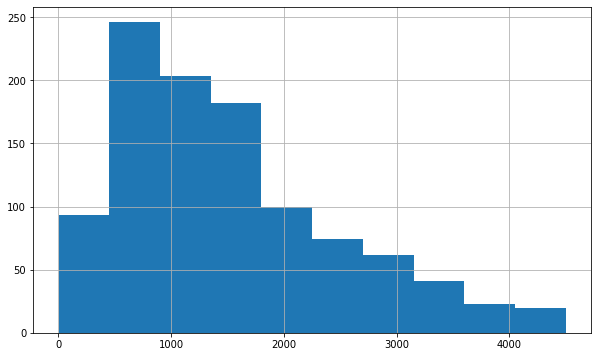

In [139]:
# divide price into groups
train_data.room_price.hist(bins=10)
# split the price into 6 groups
train_data2 = pd.DataFrame()
train_data2 = train_data
train_data2['price_group'] = train_data.room_price.apply(lambda x: 1 if x<=500 else(2 if x <=1000 else(3 if x<=1500 else(4 if x<=2000 
                                                                                                                        else(5 if x<=2500 
                                                                                                                             else 6)))))
                                                                                                    

## 4. 1 Random forest classifier 

In [140]:
from sklearn.ensemble import RandomForestClassifier

X = train_data2.iloc[:,1:-1].values
y = train_data2.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

rfc = RandomForestClassifier(n_estimators=100) # too many will waste computation power
clf = rfc.fit(X_train, y_train.values.ravel()) # ravel will give the right format for random forest

predictions = rfc.predict(X_test)

0.39712918660287083
              precision    recall  f1-score   support

           1       0.50      0.60      0.55        20
           2       0.38      0.58      0.46        50
           3       0.44      0.27      0.34        51
           4       0.35      0.29      0.32        38
           5       0.38      0.15      0.21        20
           6       0.38      0.47      0.42        30

    accuracy                           0.40       209
   macro avg       0.40      0.39      0.38       209
weighted avg       0.40      0.40      0.38       209

[[12  6  2  0  0  0]
 [ 7 29  6  5  0  3]
 [ 2 23 14  5  1  6]
 [ 2  8  6 11  1 10]
 [ 0  5  3  5  3  4]
 [ 1  6  1  5  3 14]]


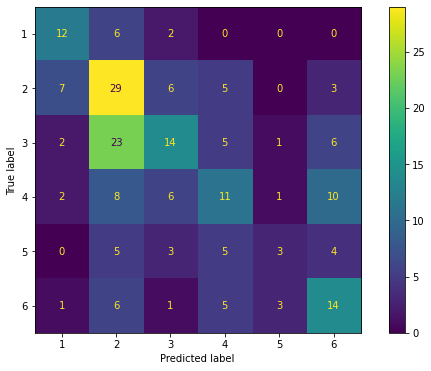

In [141]:
print(accuracy_score(y_test, predictions))
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import plot_confusion_matrix

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test,predictions))
plot_confusion_matrix(rfc, X_test, y_test)


## 4.2 Neural Network classifier

In [142]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
encoder = OneHotEncoder()
group = encoder.fit_transform(train_data[['price_group']])
ydf = pd.DataFrame(group.toarray(), columns=encoder.categories_)

train_data_encoded = pd.concat([train_data.iloc[:,1:-1], ydf], axis=1)

In [143]:
train_data_encoded.iloc[:,0:-6]

,image_count,adult_occupancy,child_occupancy,num_amenities,zones,descr_len,deluxe,num_simhotel,wifi,ac,...,acceptance_rate,response_label,Apartment,Homestay,Hotel,House,Lodge,Resort,Spa,Villa
0,3.0,3.0,2.0,1.0,2.0,125.0,0.0,0.0,0.0,0.0,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,2.0,2.0,2.0,0.0,103.0,0.0,6.0,0.0,1.0,...,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,18.0,2.0,2.0,4.0,3.0,106.0,1.0,14.0,0.0,1.0,...,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,9.0,1.0,2.0,7.0,2.0,126.0,0.0,0.0,1.0,1.0,...,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,5.0,1.0,2.0,4.0,0.0,98.0,0.0,10.0,1.0,1.0,...,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1135,15.0,1.0,2.0,1.0,0.0,147.0,0.0,14.0,1.0,0.0,...,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1136,13.0,1.0,2.0,1.0,0.0,119.0,1.0,12.0,0.0,0.0,...,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1137,16.0,1.0,2.0,1.0,0.0,98.0,0.0,3.0,0.0,0.0,...,100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [144]:
# neural network 

# define x, y
X = train_data_encoded.iloc[:,0:-6].values
y = train_data_encoded.iloc[:,-6:].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

# define NN baseline  model
nn = Sequential()
nn.add(Dense(21, activation='relu'))
nn.add(Dense(8,activation='relu'))
nn.add(Dense(6, activation='softmax'))
nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
nn.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
29/29 [==============================] - 1s 9ms/step - loss: nan - accuracy: 0.1885 - val_loss: nan - val_accuracy: 0.2115
Epoch 2/20
29/29 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.1789 - val_loss: nan - val_accuracy: 0.2115
Epoch 3/20
29/29 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.2066 - val_loss: nan - val_accuracy: 0.2115
Epoch 4/20
29/29 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.1742 - val_loss: nan - val_accuracy: 0.2115
Epoch 5/20
29/29 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.1810 - val_loss: nan - val_accuracy: 0.2115
Epoch 6/20
29/29 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.1672 - val_loss: nan - val_accuracy: 0.2115
Epoch 7/20
29/29 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.1767 - val_loss: nan - val_accuracy: 0.2115
Epoch 8/20
29/29 [==============================] - 0s 2ms/ste

* Accuracy using NN is around 19.38%, much lowerer than random forest. 